In [22]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

sys.path.append('src')
from train_test import train_test_split
from preprocessing import to_ratings, to_weights,  build_get_negative_ratings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Uploading the original dataset (uncomment if you need)

In [23]:
# ! sudo apt install curl
# ! curl -O  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz

In [24]:
# ! tar -xf ./lastfm-dataset-360K.tar.gz

### Reading the dataset

In [25]:
lastfm_360_demo = pd.read_csv('lastfm-dataset-360K/usersha1-profile.tsv', sep='\t', header=None,
                             names=['user_email', 'gender', 'age', 'country', 'signup'])
lastfm_360_behav = pd.read_csv('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, 
                              names=['user_email', 'artist_id', 'artist_name', 'plays'])

In [26]:
lastfm_360_demo = lastfm_360_demo[lastfm_360_demo['country'] == 'United States']
lastfm_360_behav = lastfm_360_behav[lastfm_360_behav['user_email'].isin(lastfm_360_demo['user_email'].unique())]

Transform "signup" column into datetime type

In [27]:
lastfm_360_demo["signup"] = pd.to_datetime(lastfm_360_demo.signup)

In [28]:
lastfm_360_demo["signup"].min()

Timestamp('2002-10-29 00:00:00')

In [29]:
lastfm_360_demo["signup"].max()

Timestamp('2009-11-02 00:00:00')

Make users' IDs as numbers

In [30]:
uniq_users = lastfm_360_demo['user_email'].unique()
upd_users_ids = dict((id_, i) for i, id_ in enumerate(uniq_users))
lastfm_360_demo['user_email'] = lastfm_360_demo['user_email'].map(lambda x: upd_users_ids[x])

### Exploring and cleaning demographic data

In [31]:
lastfm_360_demo.head()

,user_email,gender,age,country,signup
4,0,m,28.0,United States,2006-01-27
11,1,NaN,23.0,United States,2007-05-12
15,2,m,23.0,United States,2005-08-19
19,3,m,30.0,United States,2006-08-23
21,4,f,26.0,United States,2008-12-05


In [32]:
lastfm_360_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67044 entries, 4 to 359344
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_email  67044 non-null  int64         
 1   gender      60534 non-null  object        
 2   age         52286 non-null  float64       
 3   country     67044 non-null  object        
 4   signup      67044 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [33]:
lastfm_360_demo.describe(include='all', datetime_is_numeric=True)

,user_email,gender,age,country,signup
count,67044.000000,60534,52286.000000,67044,67044
unique,NaN,2,NaN,1,NaN
top,NaN,m,NaN,United States,NaN
freq,NaN,42730,NaN,67044,NaN
mean,33521.500000,NaN,26.052041,NaN,2007-04-18 18:15:36.889207040
min,0.000000,NaN,-1337.000000,NaN,2002-10-29 00:00:00
25%,16760.750000,NaN,20.000000,NaN,2006-05-09 00:00:00
50%,33521.500000,NaN,23.000000,NaN,2007-05-12 00:00:00
75%,50282.250000,NaN,29.000000,NaN,2008-05-19 00:00:00
max,67043.000000,NaN,109.000000,NaN,2009-11-02 00:00:00


Then, we should process demographic data. First, we put unrealistic ages as NaNs.

In [34]:
ages = lastfm_360_demo['age'].unique()
lastfm_360_demo['age'].replace(ages[ages > 99], np.nan, inplace=True)
lastfm_360_demo['age'].replace(ages[ages < 8], np.nan, inplace=True)

Make one-hot encoding for gender, country, and age with sure that NaNs have some pattern

In [35]:
lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['gender']))
lastfm_360_demo = lastfm_360_demo.drop('gender', axis=1)

# lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['country']))
# lastfm_360_demo = lastfm_360_demo.drop('country', axis=1)

lastfm_360_demo = lastfm_360_demo.join(pd.get_dummies(lastfm_360_demo['age']))
lastfm_360_demo = lastfm_360_demo.drop('age', axis=1)

Extract features from sign-up date

In [36]:
lastfm_360_demo['year'] = lastfm_360_demo['signup'].dt.year
lastfm_360_demo['month'] = lastfm_360_demo['signup'].dt.month
lastfm_360_demo['weekday'] = lastfm_360_demo['signup'].dt.weekday
lastfm_360_demo['day'] = lastfm_360_demo['signup'].dt.day
lastfm_360_demo = lastfm_360_demo.drop(columns='signup') 
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['year'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['month'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['day'])], axis=1)
lastfm_360_demo = pd.concat([lastfm_360_demo, pd.get_dummies(lastfm_360_demo['weekday'])], axis=1)
lastfm_360_demo = lastfm_360_demo.drop(columns=['year', 'month', 'weekday', 'day']) 

### Exploring and cleaning behavioral data

In [37]:
lastfm_360_behav.head()

,user_email,artist_id,artist_name,plays
195,00007a47085b9aab8af55f52ec8846ac479ac4fe,0110e63e-0a9b-4818-af8e-41e180c20b9a,devendra banhart,456
196,00007a47085b9aab8af55f52ec8846ac479ac4fe,69158f97-4c07-4c4e-baf8-4e4ab1ed666e,boards of canada,407
197,00007a47085b9aab8af55f52ec8846ac479ac4fe,e162b2eb-6a42-4240-8c1b-c94d9a0acb73,cocorosie,386
198,00007a47085b9aab8af55f52ec8846ac479ac4fe,f22942a1-6f70-4f48-866e-238cb2308fbd,aphex twin,213
199,00007a47085b9aab8af55f52ec8846ac479ac4fe,0c751690-c784-4a4f-b1e4-c1de27d47581,animal collective,203


In [38]:
lastfm_360_behav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3336272 entries, 195 to 17535535
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_email   object
 1   artist_id    object
 2   artist_name  object
 3   plays        int64 
dtypes: int64(1), object(3)
memory usage: 127.3+ MB


In [39]:
lastfm_360_behav.describe(include='all', datetime_is_numeric=True)

,user_email,artist_id,artist_name,plays
count,3336272,3298989,3336237,3.336272e+06
unique,66949,84506,114123,NaN
top,13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,the beatles,NaN
freq,166,22186,22180,NaN
mean,NaN,NaN,NaN,2.555277e+02
std,NaN,NaN,NaN,7.066286e+02
min,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,4.700000e+01
50%,NaN,NaN,NaN,1.180000e+02
75%,NaN,NaN,NaN,2.660000e+02


In [40]:
lastfm_360_behav.isna().sum(0)

user_email         0
artist_id      37283
artist_name       35
plays              0
dtype: int64

We drop samples with missed artist's name because there are no many of them and it is only one artist in 35 cases and an artist that doesn't have the name and the ID in 2 cases.

In [43]:
lastfm_360_behav.loc[lastfm_360_behav['artist_name'].isnull()].shape

(35, 4)

In [44]:
lastfm_360_behav = lastfm_360_behav.drop(lastfm_360_behav.loc[lastfm_360_behav['artist_name'].isnull()].index)

Since the part of samples where ID is missed makes up about 1% of data and don't include important systematic patterns like feats or the most popular artists, we drop it for simplicity. (another approach would be to say that the ID is equal names but this might make data incorrect because names are not unique at all)

In [48]:
lastfm_360_behav.loc[lastfm_360_behav['artist_id'].isnull()]

(37281, 4)

In [50]:
lastfm_360_behav = lastfm_360_behav.drop(lastfm_360_behav.loc[lastfm_360_behav['artist_id'].isnull()].index)

There are cases where one ID corresponds several artists names. We fix it by assigning one name to all entries of a given ID

In [51]:
uniq_artist_names = lastfm_360_behav.groupby('artist_id')['artist_name'].unique()
lastfm_360_behav['artist_name'] = lastfm_360_behav.apply(lambda x: uniq_artist_names[x['artist_id']][0], axis=1)

Make artists' and users' IDs as numbers

In [24]:
uniq_artist_ids = lastfm_360_behav['artist_id'].unique()
upd_ids = dict((id_, i) for i, id_ in enumerate(uniq_artist_ids))
lastfm_360_behav['artist_id'] = lastfm_360_behav['artist_id'].map(lambda x: upd_ids[x])
lastfm_360_behav['user_email'] = lastfm_360_behav['user_email'].map(lambda x: upd_users_ids[x])

Drop users who have a number of plays equals to number of different users because the following processing can result in unreasonable high ratings for artists and these users loooks like those who came to check the platform but don't use it permanently. There are only 18 such users.

In [25]:
inactive_users = lastfm_360_behav.groupby('user_email').filter(
    lambda x: x['plays'].count() == x['plays'].sum())['user_email'].unique()
lastfm_360_behav = lastfm_360_behav[~lastfm_360_behav['user_email'].isin(inactive_users)]
lastfm_360_demo = lastfm_360_demo[~lastfm_360_demo['user_email'].isin(inactive_users)]

In [26]:
print(lastfm_360_behav.artist_id.unique().shape)
print(lastfm_360_behav.user_email.unique().shape)
print(lastfm_360_demo.user_email.unique().shape)

(160098,)
(358726,)
(359217,)


We can see that there are more users that don't have records in the behavioral part of the dataset. Let us drop them because it is about 500 users, i.e. ~0.1%.

In [27]:
no_plays_users = list(set(lastfm_360_demo.user_email.unique()).symmetric_difference(
    set(lastfm_360_behav.user_email.unique())))
lastfm_360_demo = lastfm_360_demo[~lastfm_360_demo.user_email.isin(no_plays_users)]

In [28]:
print(lastfm_360_behav.user_email.unique().shape)
print(lastfm_360_demo.user_email.unique().shape)

(358726,)
(358726,)


### Transforming implicit feedback to explicit (plays $\to$ ratings)

[Text(-250.0, 0, 'qntal'),
 Text(0.0, 0, 'the beatles'),
 Text(250.0, 0, 'nick drake'),
 Text(500.0, 0, 'kate nash'),
 Text(750.0, 0, 'amy macdonald'),
 Text(1000.0, 0, 'the lawrence arms'),
 Text(1250.0, 0, '(hed) p.e'),
 Text(1500.0, 0, 'meat loaf'),
 Text(1750.0, 0, 'qntal'),
 Text(2000.0, 0, ''),
 Text(2250.0, 0, '')]

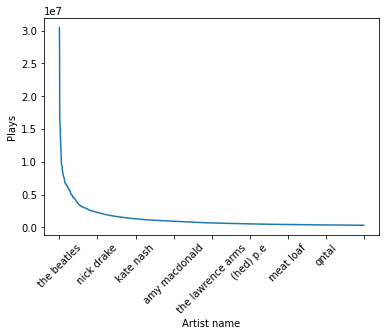

In [29]:
artist_plays = lastfm_360_behav.groupby('artist_name')['plays'].sum().sort_values(ascending=False)
# sns.distplot(artist_plays[:100])
g = artist_plays[:2000].plot()
g.set_ylabel('Plays')
g.set_xlabel('Artist name')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
# plt.savefig('plays_vs_artists.png')

We can see that the distribution of the plays is highly concentrated around a few hundreds of plays. 
## write something here

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='plays', ylabel='Density'>

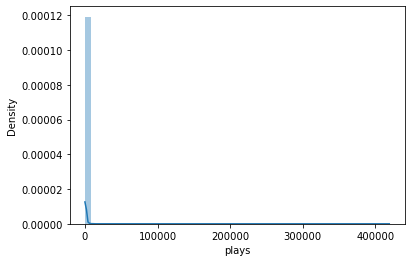

In [30]:
sns.distplot(lastfm_360_behav['plays'])

In [31]:
lastfm_360_behav['norm_plays'] = lastfm_360_behav.groupby('user_email')['plays'].apply(lambda x: x / x.sum())

In [32]:
groupped = lastfm_360_behav.groupby('user_email').apply(to_ratings)
lastfm_360_behav = groupped.drop(columns='user_email').reset_index().drop(columns='level_1').rename(
    columns={'norm_plays': 'rating'})

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

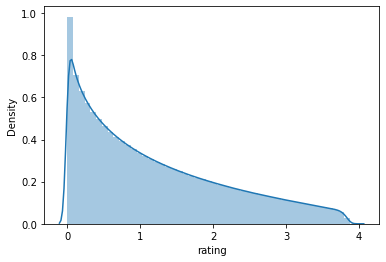

In [33]:
# lastfm_360_behav['log_plays'] = np.log(lastfm_360_behav['plays'])
sns.distplot(lastfm_360_behav['rating'])

/home/alex/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


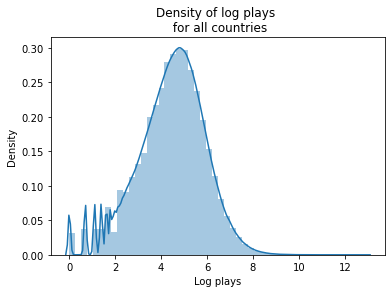

In [34]:
g = sns.distplot(np.log(lastfm_360_behav['plays']))
g.set_title('Density of log plays \n for all countries')
g.set_xlabel('Log plays')
plt.savefig('figs/log_plays_all.png')

In [35]:
lastfm_360_demo.shape, lastfm_360_behav.shape,

((358726, 154), (17307967, 5))

In [36]:
((66928, 152), (3298851, 5))

((66928, 152), (3298851, 5))

### Splitting behavioral data into train, validation and test

In [ ]:
ratings = lastfm_360_behav[['user_email', 'artist_id', 'rating']]
train, test = train_test_split(ratings, test_frac=0.1)
train, valid = train_test_split(train, test_frac=0.1)

In [ ]:
lastfm_360_behav.to_csv('lastfm-dataset-360K/behav-360k-processed.csv', index=False)
lastfm_360_demo.to_csv('lastfm-dataset-360K/demo-360k-processed.csv', index=False)

In [ ]:
del lastfm_360_behav
del lastfm_360_demo

In [ ]:
all_artists = set(ratings['artist_id'].unique())
get_negative_ratings = build_get_negative_ratings(all_artists, factor=10)
negative_ratings = ratings.groupby('user_email').progress_apply(get_negative_ratings)
negative_ratings = negative_ratings.reset_index().drop(columns='level_1')

In [ ]:
negative_train, negative_test = train_test_split(negative_ratings, test_frac=0.9)
negative_train, negative_valid = train_test_split(negative_train, test_frac=0.1)

In [ ]:
train = train.append(negative_train)
valid = valid.append(negative_valid)
test = test.append(negative_test)

In [ ]:
train = train.sample(frac=1).reset_index(drop=True) 

###### Computing weight of artists for each user

In [ ]:
# train['weight'] = np.floor(train['rating']).astype(np.int8)
# train = train.groupby('user_email').apply(to_weights)

In [ ]:
print(train.shape, test.shape, ratings.shape)

### Saving clean dataset

In [ ]:
train.to_csv('lastfm-dataset-360K/train.csv', index=False)
valid.to_csv('lastfm-dataset-360K/valid.csv', index=False)
test.to_csv('lastfm-dataset-360K/test.csv', index=False)

###### Selecting users to test artists recommendations

In [ ]:
# diversity = lastfm_360_behav.groupby('user_email')['user_email'].count()

In [ ]:
# g = sns.distplot(diversity)
# g.set_xlabel('Number of distinct artists')
# plt.savefig('diversity.png')

In [ ]:
# np.save('lastfm-dataset-360K/test_users', diversity[diversity >= 50].sample(1000).index)